In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet
from pyramid.arima import auto_arima

from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Plotting functions

In [2]:
def plotting_features(exog, mode):
    """
    plotting features
    """
    
    if mode == 'prophet':
        Exog = exog.values
        
    elif mode == 'pyramid':
        Exog = exog

    else:
        print("check mode")
        return None
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots
    
    fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)
    

    ax1.plot(Time,Exog[:,0])
    ax1.set_ylabel('exog_1', bbox=box)


    ax3.set_ylabel('exog_2',bbox=box)
    ax3.plot(Time,Exog[:,1])

    labelx = -0.3  # axes coords

    ax2.plot(Time,Exog[:,2])
    ax2.set_ylabel('exog_3', bbox=box)
    ax2.yaxis.set_label_coords(labelx, 0.5)


    ax4.plot(Time,Exog[:,3])
    ax4.set_ylabel('exog_4', bbox=box)
    ax4.yaxis.set_label_coords(labelx, 0.5)

    plt.show()
    
    pass

In [3]:
def plotting_time_series(y_without_lags, y_with_lags, mode):
    """
    Plot two time series
    """
    if mode == 'prophet':
        ts_without_lags = data_without_lags["y"].values
        ts_with_lags = data_with_lags["y"].values
        
    elif mode == 'pyramid':
        ts_without_lags = y_without_lags
        ts_with_lags = y_with_lags
        
    else:
        print("Check mode")
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (3, 7))
    fig.subplots_adjust(top = 2, bottom = 1,  right = 2, left = 0, hspace = 0.2)

    ax1.plot(Time, ts_without_lags)
    ax1.set_ylabel("value", bbox = box)
    ax1.set_title("y without lags", bbox = box)


    ax2.set_ylabel("value", bbox = box)
    ax2.plot(Time, ts_with_lags)
    ax2.set_title("y with lags", bbox = box)

    #fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.show()
    
    pass

In [4]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, mode, description):
    
    """
    Plots the original time series and it prediction
    """
    if mode == 'prophet':
        ts = time_series["y"].values
        train_pr = train_prediction["yhat"].values
        test_pr = test_prediction["yhat"].values
    
    elif mode == 'pyramid':
        train_pr = train_prediction
        test_pr = test_prediction
        ts = time_series
        
    
    else:
        print("Check mode")
        return None
    
    plt.figure(figsize=(10,7))

    plt.plot(Time, ts, label = "true")
    
    plt.plot(Time[start_point+1: end_point], np.concatenate([train_pr, test_pr])[1:], 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3)))


    plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

# Extra functions

In [5]:
def generate_problem_synthetic_2_AR(n_elements, mode = 'prophet', seed = 123, noise_scale = None):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([f_1(Time,2,1,1,0.1,0), 
                           f_1(Time,1,0.5,0.2,-0.1,0.01), 
                           f_1(Time,1,0.6,1,0.5,0.02), 
                           f_1(Time,1,0.7,0.5,0.5,-0.02) + 10], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_1(Exog,noise_scale=noise_scale)
    
    y_with_lags = generate_ts_2(Exog,noise_scale=noise_scale)
    
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog)
        exog.columns = ["f1", "f2", "f3", "f4"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [6]:
def generate_problem_nonlinear(n_elements, mode = 'prophet', seed = 123, noise_scale = None):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([f_1(Time), f_2(Time), f_3(Time, period=12), f_4(Time, period=12)], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_nonlinear(Exog, noise_scale = noise_scale)
    
    y_with_lags = generate_ts_nonlinear_with_lags(Exog, noise_scale = noise_scale)
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog)
        exog.columns = ["f1", "f2", "f3", "f4"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [7]:
def train_test_split(data, start_point, middle_point, end_point, mode, exog_flag = False):
    """
    Make train-test-split using input parameters
    """
    
    if mode == 'prophet':
        data_train = data.iloc[start_point: middle_point].copy()
        data_test = data.iloc[middle_point: end_point].copy()
        
        
        if exog_flag == False:
            
            y_test = data_test["y"].values
            del data_test["y"]
            
            return data_train, data_test, y_test
        
        else:
            
            return data_train, data_test
    
    elif mode == 'pyramid':
        
        data_train = data[start_point: middle_point]
        data_test = data[middle_point: end_point]
        
        if exog_flag == False:
            return data_train, data_test, data_test
        else:
            return data_train, data_test
        
    else:
        print("Check mode")
        return None, None, None

In [8]:
def Fit(mode, data_train, exog_train = None, params = None):
    
    """
    Fit the models
    """
    
    if mode == 'prophet':
        model = fit_prophet(data_train = data_train, exog_train = exog_train, params = params)
        
    elif mode == 'pyramid':
        model = fit_pyramid(data_train = data_train, exog_train = exog_train, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [9]:
def Predict(mode, model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Model prediction on train and test
    """
    
    if mode == 'prophet':
        model = predict_prophet(model = model, data_train = data_train, data_test = data_test, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    elif mode == 'pyramid':
        model = predict_pyramid(model = model, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [10]:
def fit_prophet(data_train, exog_train = None, params = None):
    
    """
    Method fit for prophet
    """
    
    data_train_new = data_train.copy()
    
    model = Prophet()
    
    if exog_train is not None:
        
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        
        model.add_regressor("f1")
        model.add_regressor("f2")
        model.add_regressor("f3")
        model.add_regressor("f4")

    model.fit(data_train_new)
    
    return model

In [11]:
def predict_prophet(model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Prediction for prophet
    """
    
    data_test_new = data_test.copy()
    data_train_new = data_train.copy()
    
    if exog_train is not None:
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        data_test_new = pd.merge(data_test_new, exog_test, on = "ds")
    
    forecast_train = model.predict(data_train_new)
    forecast_test = model.predict(data_test_new)
    
    return forecast_train, forecast_test

In [12]:
def fit_pyramid(data_train, exog_train = None, params = None):

    """
    pyramid_mode {"stepwise", "random_search"}

    """
    
    if params['pyramid_mode'] == "stepwise":
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5,
        m=params['period'], n_jobs = params['n_jobs'], scoring = params['scoring'], 
        out_of_sample_size = params['out_of_sample_size'], 
        start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, stepwise=True)
    
    elif params['pyramid_mode'] == 'random_search':
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5, 
        m=params['period'], scoring = params['scoring'], out_of_sample_size = params['out_of_sample_size'],
        start_P=0, start_Q = 0, n_jobs=params['n_jobs'], max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, 
        stepwise=False, random=True, random_state=params['random_state'], n_fits = params['n_fits'])
    
    return model

In [13]:
def predict_pyramid(model, exog_train = None, exog_test = None, params = None):
    
    predict_in_sample = model.predict_in_sample(exogenous = exog_train, dynamic = params['dynamic'])
    predict_out_of_sample = model.predict(n_periods = params['n_periods'], exogenous = exog_test)
    
    return predict_in_sample, predict_out_of_sample

# Data generation functions

In [14]:
def f_1(time,start,k,sigma,c,ct,seed = 123):
    """
    time: np.array (len_ts,)
    k: parameter of AR(1)
    sigma: variance of noise
    c: constant part of trend
    ct : koef of linear part of trend
    """
    len_ts = time.shape[0]
    np.random.seed(seed)
    f = np.empty(len_ts)
    f[0] = start
    w = np.random.normal(size = len_ts, scale = sigma)
    for i in range(1,len_ts):
        f[i] = k * f[i-1] + c +ct * i + w[i]    
    return f.reshape(-1,1)

def generate_ts_1(exog, noise_scale = None):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    y = y.squeeze()
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y

def generate_ts_2(exog, noise_scale = None):
    
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y


def generate_ts_nonlinear(exog, noise_scale = None):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 1] * exog[:, 2] + exog[:, 2] / exog[:, 3]
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y

def generate_ts_nonlinear_with_lags(exog, noise_scale = None):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    y = 0.4 * exog[:, 0] * exog[:, 2] + exog[:, 1] / exog[:, 2]
    
    for i in range(2, exog.shape[0]):
        
        y[i] = y[i] + 0.2 * y[i-1] + 0.2 * y[i-2] + 0.1 * y[i-1]
    
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
        
    return y


# Testing on the last dataset - linear case

# Prophet

In [15]:
# Global_mode
global_mode = 'prophet'
noise_scale = None

# Generate problem

In [16]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, 
                        mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

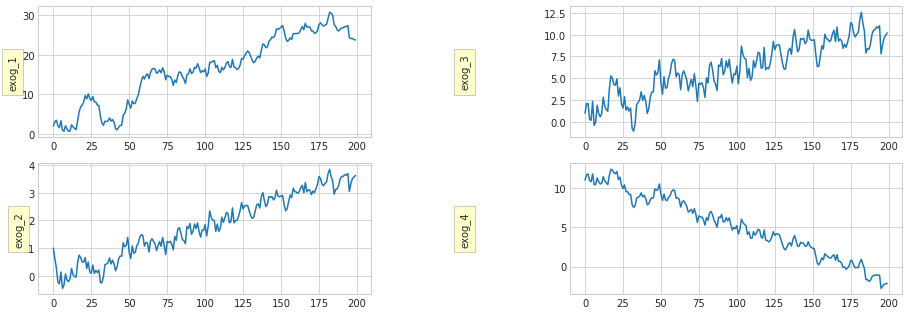

In [17]:
plotting_features(exog, global_mode)

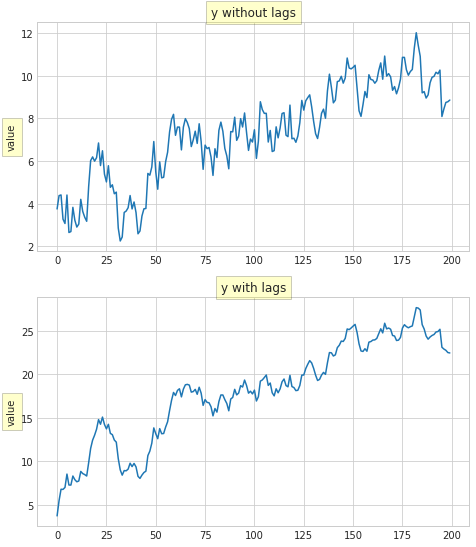

In [18]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [19]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet without lags without noise without exog

In [20]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [21]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

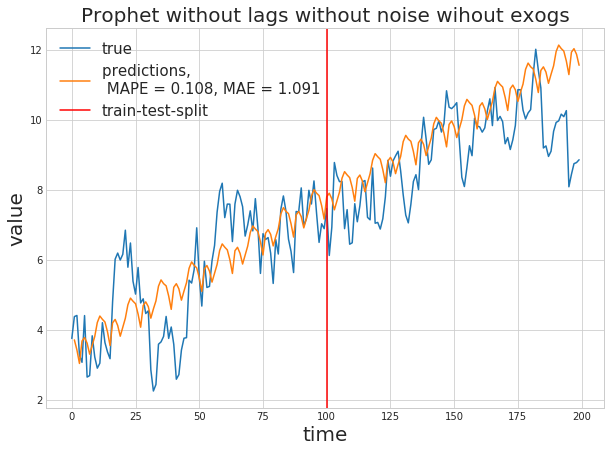

In [22]:
description = "Prophet without lags without noise wihout exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet without lags without noise with exogs 

In [23]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

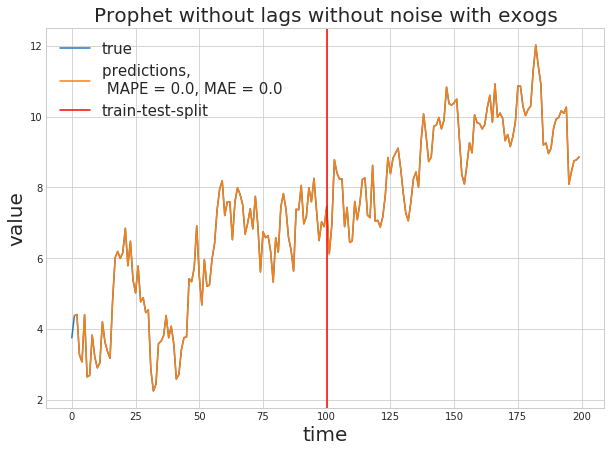

In [25]:
description = "Prophet without lags without noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet with lags without noise without exogs

In [26]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

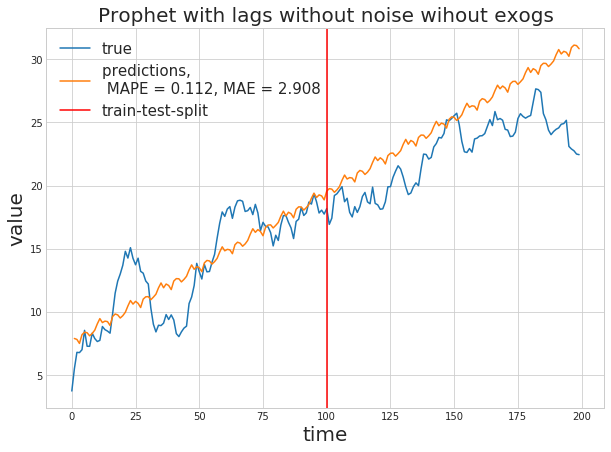

In [28]:
description = "Prophet with lags without noise wihout exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
                             y_test_with_lags, global_mode, description)

# Prophet with lags without noise with exogs

In [29]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [30]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

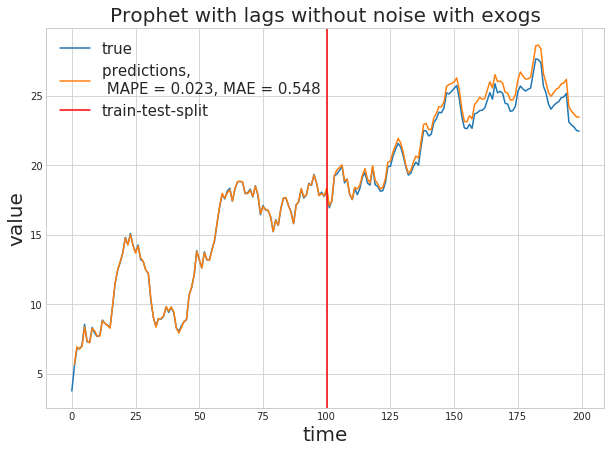

In [31]:
description = "Prophet with lags without noise with exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid Approach

In [32]:
# Global_mode
global_mode = 'pyramid'
noise_scale = None

# Generate problem

In [33]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, 
                                mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

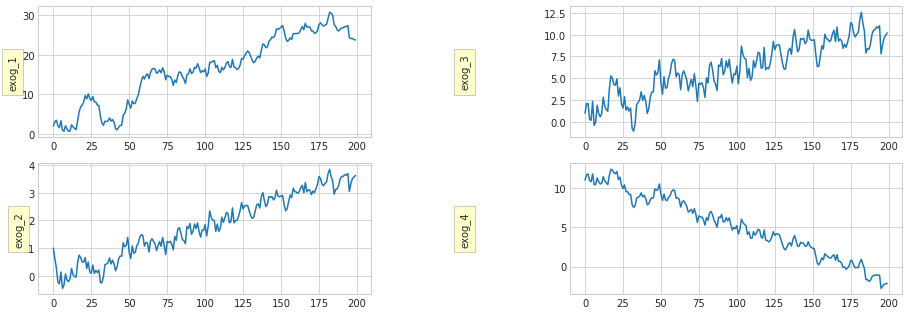

In [34]:
plotting_features(exog, global_mode)

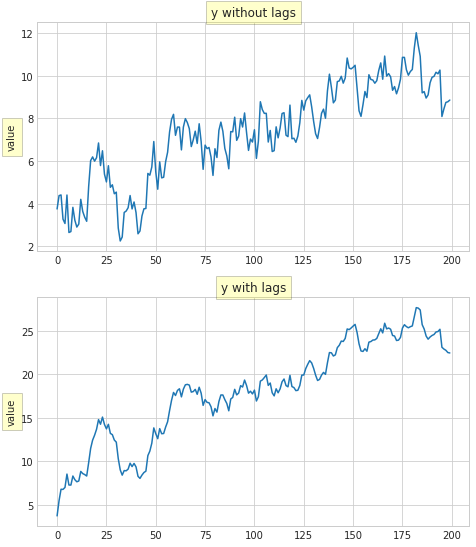

In [35]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [36]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Pyramid without lags without noise without exogs

In [108]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [109]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -120.497
Date:                Thu, 19 Jul 2018   AIC                            250.995
Time:                        15:28:52   BIC                            263.970
Sample:                             0   HQIC                           256.245
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0494      0.083      0.598      0.550      -0.112       0.211
ar.L1         -0.5437      0.272     -1.998      0.046      -1.077      -0.010
ma.L1          0.3184      0.246      1.294      0.196      -0.164       0.801
ma.L2         -0.3570      0.102     -3.497      0.000      -0.557      -0.157
sigma2         0.6662      0.114      5.843      0.000       0.443       0.890
===================================================================================
Ljung-Box (Q):                       32.95   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.78   Prob(JB):                         0.40
Heteroskedasticity (H):               0.96   Skew:                             0.18
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [110]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

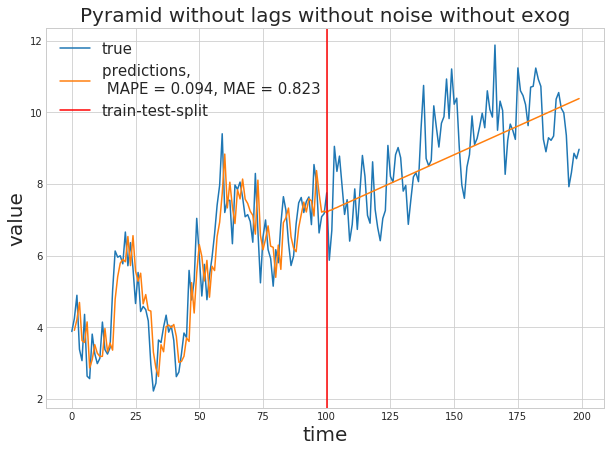

In [111]:
description = "Pyramid without lags without noise without exog"
plot_results(data_without_lags, Time, train_prediction, 
             test_prediction, y_test_without_lags, global_mode, description)

# Pyramid without lags without noise with exog

In [112]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [113]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

In [114]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

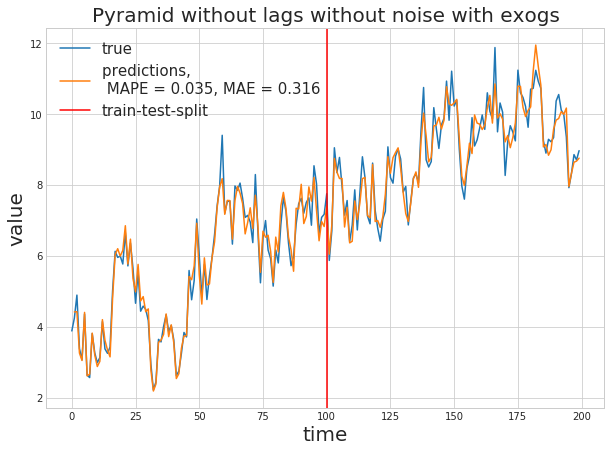

In [115]:
description = "Pyramid without lags without noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, 
             global_mode, description)

# Pyramid with lags without noise without exogs

In [104]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [105]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -163.183
Date:                Thu, 19 Jul 2018   AIC                            332.365
Time:                        15:28:37   BIC                            340.151
Sample:                             0   HQIC                           335.515
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1359      0.100      1.358      0.174      -0.060       0.332
ma.L1         -0.2244      0.103     -2.176      0.030      -0.427      -0.022
sigma2         1.5812      0.213      7.429      0.000       1.164       1.998
===================================================================================
Ljung-Box (Q):                       30.44   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.86   Prob(JB):                         0.51
Heteroskedasticity (H):               1.02   Skew:                             0.24
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [106]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

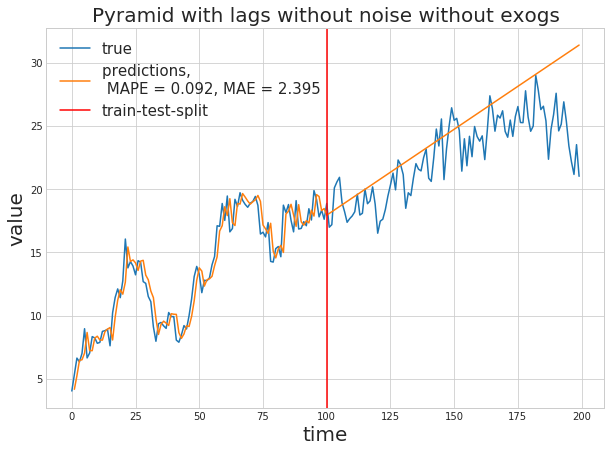

In [107]:
description = "Pyramid with lags without noise without exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid with lags without noise with exog

In [116]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [117]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

In [118]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -119.613
Date:                Thu, 19 Jul 2018   AIC                            255.225
Time:                        15:29:12   BIC                            276.067
Sample:                             0   HQIC                           263.660
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.8356      1.302      3.714      0.000       2.284       7.387
x1             0.7112      0.069     10.378      0.000       0.577       0.845
x2            -3.8924      1.640     -2.374      0.018      -7.106      -0.679
x3             0.9992      0.448      2.233      0.026       0.122       1.876
x4            -0.3711      0.216     -1.719      0.086      -0.794       0.052
ar.L1          0.2647      0.091      2.900      0.004       0.086       0.444
ar.L2          0.2291      0.090      2.533      0.011       0.052       0.406
sigma2         0.6331      0.081      7.836      0.000       0.475       0.791
===================================================================================
Ljung-Box (Q):                       25.84   Jarque-Bera (JB):                 8.04
Prob(Q):                              0.96   Prob(JB):                         0.02
Heteroskedasticity (H):               1.48   Skew:                            -0.50
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

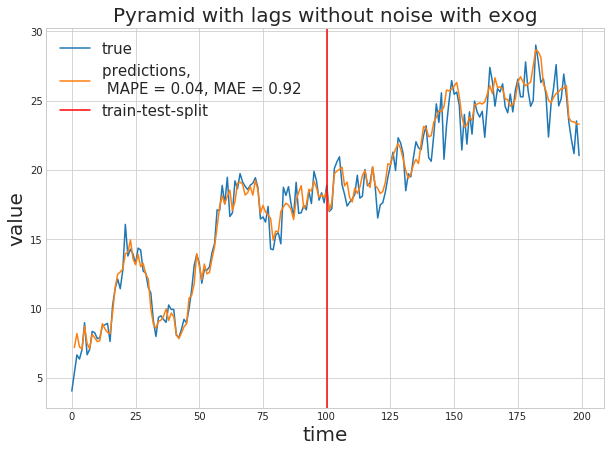

In [120]:
description = "Pyramid with lags without noise with exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise

# Testing on the last dataset - linear case - with noise

# Prophet

In [121]:
# Global_mode
global_mode = 'prophet'
noise_scale = 0.05

# Generate problem

In [122]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, 
                        mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

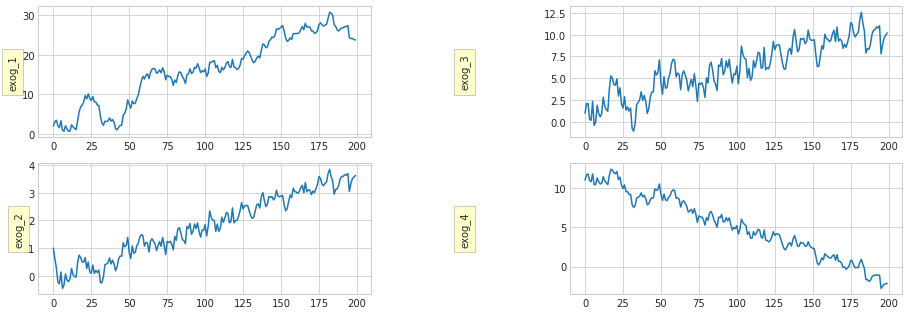

In [123]:
plotting_features(exog, global_mode)

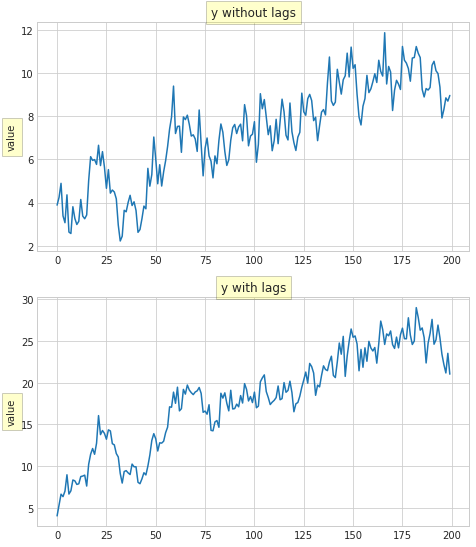

In [124]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [125]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet without lags with noise without exog

In [126]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [127]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

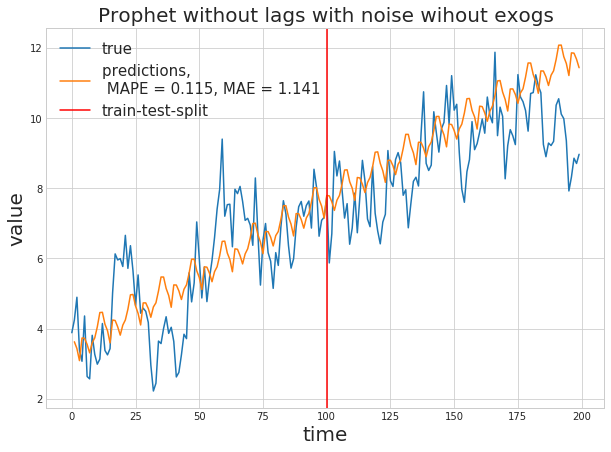

In [128]:
description = "Prophet without lags with noise wihout exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet without lags with noise with exogs 

In [129]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [130]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

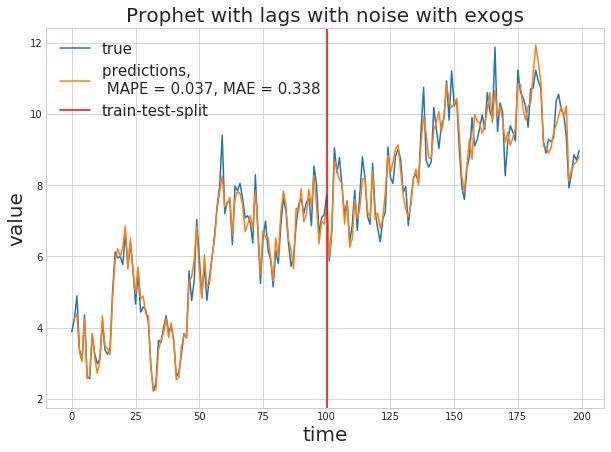

In [131]:
description = "Prophet with lags with noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet with lags with noise without exogs

In [132]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [133]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

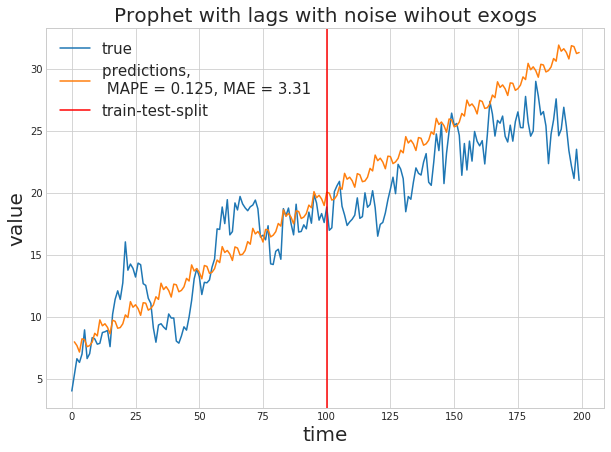

In [134]:
description = "Prophet with lags with noise wihout exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
                             y_test_with_lags, global_mode, description)

# Prophet with lags with noise with exogs

In [135]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/nurlan16/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [136]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

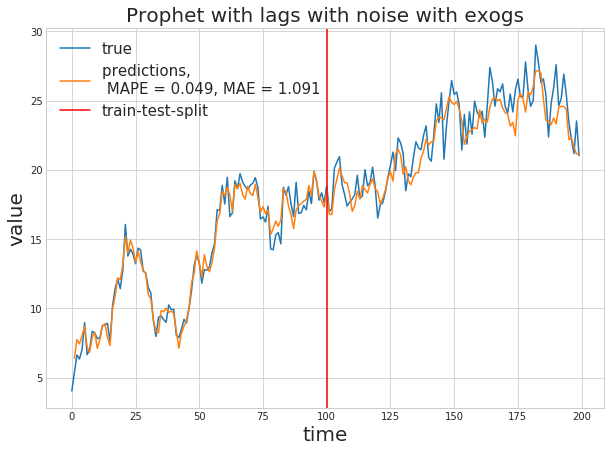

In [137]:
description = "Prophet with lags with noise with exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid Approach

In [138]:
# Global_mode
global_mode = 'pyramid'
noise_scale = 0.05

# Generate problem

In [139]:
n_samples = 200
data_without_lags, data_with_lags, exog, Time = generate_problem_synthetic_2_AR(n_samples, 
                                mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

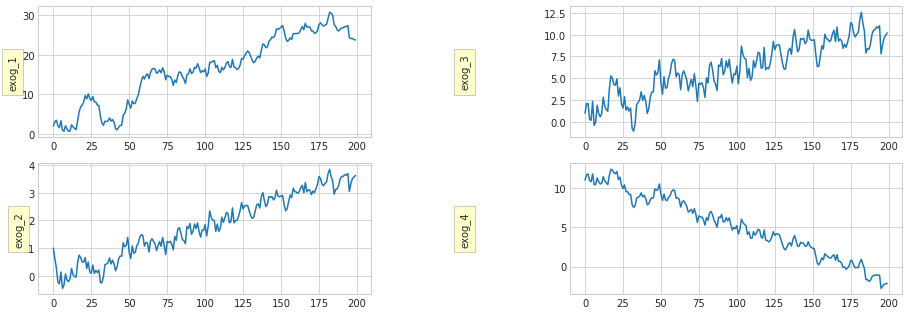

In [140]:
plotting_features(exog, global_mode)

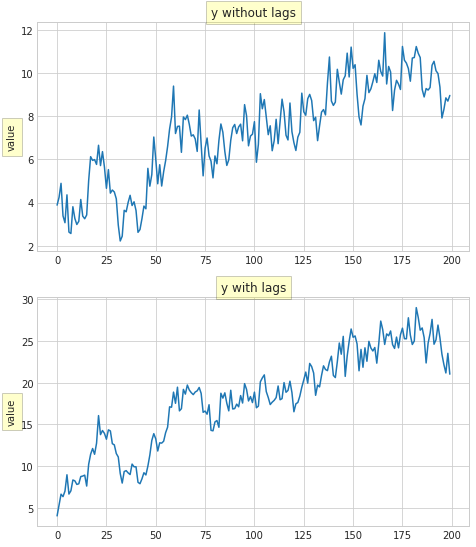

In [141]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [142]:
start_point = 0
middle_point = 100
end_point = 200

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Pyramid without lags with noise without exogs

In [145]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 1
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [144]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -120.497
Date:                Thu, 19 Jul 2018   AIC                            252.995
Time:                        15:29:38   BIC                            268.565
Sample:                             0   HQIC                           259.295
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0462      0.178      0.260      0.795      -0.302       0.394
drift       6.785e-05      0.003      0.022      0.983      -0.006       0.006
ar.L1         -0.5409      0.283     -1.913      0.056      -1.095       0.013
ma.L1          0.3165      0.254      1.247      0.213      -0.181       0.814
ma.L2         -0.3559      0.102     -3.492      0.000      -0.556      -0.156
sigma2         0.6635      0.113      5.863      0.000       0.442       0.885
===================================================================================
Ljung-Box (Q):                       32.96   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.78   Prob(JB):                         0.41
Heteroskedasticity (H):               0.96   Skew:                             0.18
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

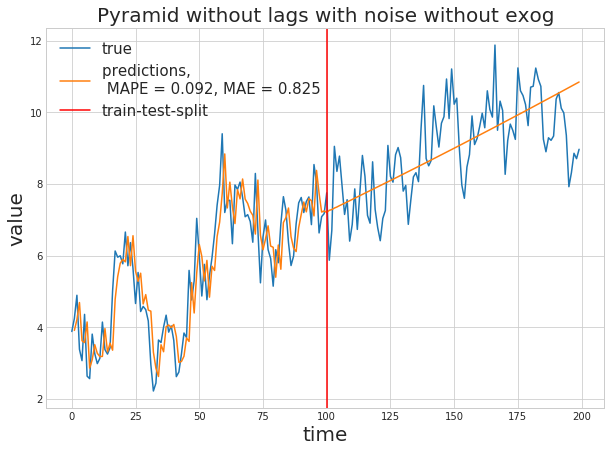

In [81]:
description = "Pyramid without lags with noise without exog"
plot_results(data_without_lags, Time, train_prediction, 
             test_prediction, y_test_without_lags, global_mode, description)

# Pyramid without lags with noise with exog

In [83]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

In [84]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

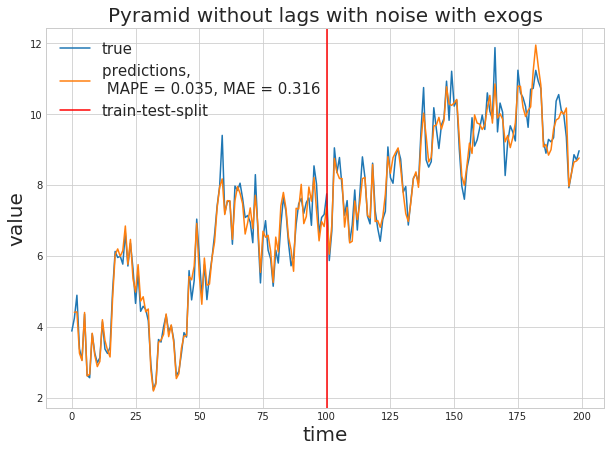

In [85]:
description = "Pyramid without lags with noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, 
             global_mode, description)

# Pyramid with lags with noise without exogs

In [96]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -163.183
Date:                Thu, 19 Jul 2018   AIC                            332.365
Time:                        15:26:21   BIC                            340.151
Sample:                             0   HQIC                           335.515
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1359      0.100      1.358      0.174      -0.060       0.332
ma.L1         -0.2244      0.103     -2.176      0.030      -0.427      -0.022
sigma2         1.5812      0.213      7.429      0.000       1.164       1.998
===================================================================================
Ljung-Box (Q):                       30.44   Jarque-Bera (JB):                 1.34
Prob(Q):                              0.86   Prob(JB):                         0.51
Heteroskedasticity (H):               1.02   Skew:                             0.24
Prob(H) (two-sided):                  0.96   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

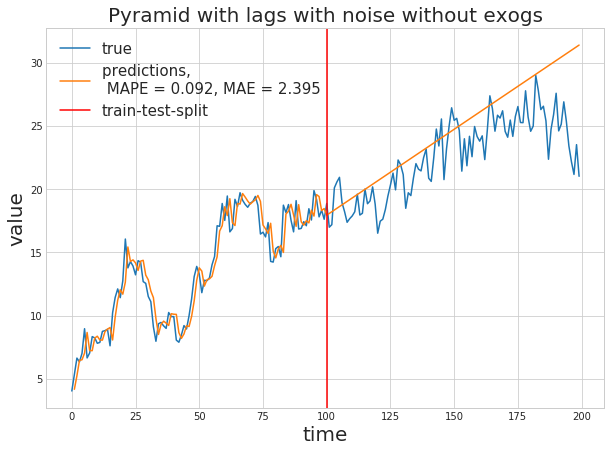

In [98]:
description = "Pyramid with lags with noise without exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid with lags with noise with exog

In [100]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

In [101]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -119.613
Date:                Thu, 19 Jul 2018   AIC                            255.225
Time:                        15:28:16   BIC                            276.067
Sample:                             0   HQIC                           263.660
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.8356      1.302      3.714      0.000       2.284       7.387
x1             0.7112      0.069     10.378      0.000       0.577       0.845
x2            -3.8924      1.640     -2.374      0.018      -7.106      -0.679
x3             0.9992      0.448      2.233      0.026       0.122       1.876
x4            -0.3711      0.216     -1.719      0.086      -0.794       0.052
ar.L1          0.2647      0.091      2.900      0.004       0.086       0.444
ar.L2          0.2291      0.090      2.533      0.011       0.052       0.406
sigma2         0.6331      0.081      7.836      0.000       0.475       0.791
===================================================================================
Ljung-Box (Q):                       25.84   Jarque-Bera (JB):                 8.04
Prob(Q):                              0.96   Prob(JB):                         0.02
Heteroskedasticity (H):               1.48   Skew:                            -0.50
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

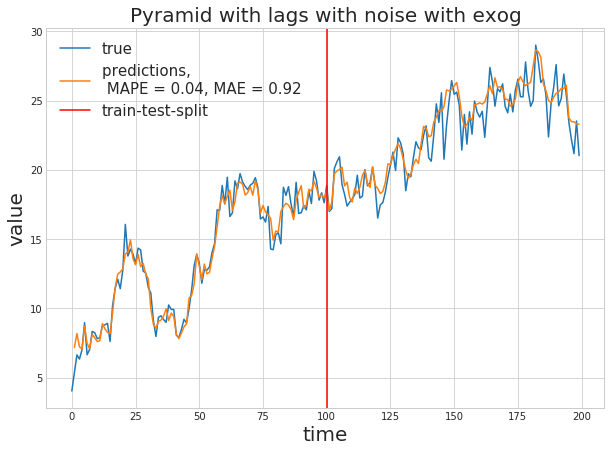

In [103]:
description = "Pyramid with lags with noise with exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)